# HMM with Poisson observations for detecting changepoints in the rate of a signal

This notebook is based on the
[Multiple Changepoint Detection and Bayesian Model Selection Notebook of TensorFlow](https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection)

In [30]:
import jax
import numpy as np
import jax.numpy as jnp
from jax.scipy import stats
from jax import jit, lax, vmap
from jax.example_libraries import optimizers
import matplotlib.pylab as plt
import seaborn as sns

try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qqq tensorflow
    import tensorflow as tf

try:
    import tensorflow_probability as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow-probability
    import tensorflow_probability as tfp

try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qqq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify

try:
    import distrax
except ModuleNotFoundError:
    %pip install -qqq distrax
    import distrax
from distrax import HMM
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

# enable jnp.float64
from jax.config import config

config.update("jax_enable_x64", True)
%matplotlib inline

## Data

The synthetic data corresponds to a single time series of counts, where the rate of the underlying generative process changes at certain points in time.

In [31]:
latexify(width_scale_factor=2, fig_height=1.5)

saving image to /home/tensor_boy/Desktop/hmm_poisson_data_latexified.pdf
Figure size: [3.  1.5]


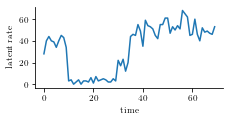

In [32]:
# Figure 29.6 (a)
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]

key = jax.random.PRNGKey(42)
keys = jax.random.split(key, num=len(true_rates))

observed_counts = jnp.concatenate(
    [
        jax.random.poisson(key, lam=rate, shape=(num_steps,))
        for (rate, num_steps, key) in zip(true_rates, true_durations, keys)
    ]
)

plt.figure()
plt.plot(observed_counts)
plt.xlabel("time")
plt.ylabel("latent rate")

sns.despine()
savefig("hmm_poisson_data")
plt.show()

## Model with fixed $K$

To model the changing Poisson rate, we use an HMM. We initially assume the number of states is known to be $K=4$. Later we will try comparing HMMs with different $K$.

We fix the initial state distribution to be uniform, and fix the transition matrix to be the following, where we set $p=0.05$:

$$ \begin{align*} z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right\}\right)\\ z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{4-1} & \text{otherwise}\end{array}\right\}\right) \end{align*}$$

In [33]:
def build_latent_state(num_states, max_num_states, daily_change_prob):
    # Give probability 0 to states outside of the current model.
    def prob(s):
        return jnp.where(s < num_states + 1, 1 / num_states, 0.0)

    states = jnp.arange(1, max_num_states + 1)
    initial_state_probs = vmap(prob)(states)

    # Build a transition matrix that transitions only within the current
    # `num_states` states.
    def transition_prob(i, s):
        return jnp.where(
            (s <= num_states) & (i <= num_states) & (1 < num_states),
            jnp.where(s == i, 1 - daily_change_prob, daily_change_prob / (num_states - 1)),
            jnp.where(s == i, 1, 0),
        )

    transition_probs = vmap(transition_prob, in_axes=(None, 0))(states, states)

    return initial_state_probs, transition_probs

In [34]:
num_states = 4
daily_change_prob = 0.05

initial_state_probs, transition_probs = build_latent_state(num_states, num_states, daily_change_prob)
print("Initial state probs:\n{}".format(initial_state_probs))
print("Transition matrix:\n{}".format(transition_probs))

Initial state probs:
[0.25 0.25 0.25 0.25]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


Now we create an HMM where the observation distribution is a Poisson with learnable parameters. We specify the parameters in log space and initialize them to random values around the log of the overall mean count (to set the scal

In [35]:
def make_hmm(log_rates, transition_probs, initial_state_probs):
    """Make a Hidden Markov Model with Poisson observation distribution."""
    return HMM(
        obs_dist=tfd.Poisson(log_rate=log_rates),
        trans_dist=distrax.Categorical(probs=transition_probs),
        init_dist=distrax.Categorical(probs=initial_state_probs),
    )

In [36]:
rng_key = jax.random.PRNGKey(0)
rng_key, rng_normal, rng_poisson = jax.random.split(rng_key, 3)

# Define variable to represent the unknown log rates.
trainable_log_rates = jnp.log(jnp.mean(observed_counts)) + jax.random.normal(rng_normal, (num_states,))
hmm = make_hmm(trainable_log_rates, transition_probs, initial_state_probs)

## Model fitting using Gradient Descent

We compute a MAP estimate of the Poisson rates $\lambda$ using batch gradient descent, using the Adam optimizer applied to the log likelihood (from the HMM) plus the log prior for $p(\lambda)$.

In [37]:
def loss_fn(trainable_log_rates, transition_probs, initial_state_probs):
    cur_hmm = make_hmm(trainable_log_rates, transition_probs, initial_state_probs)
    return -(jnp.sum(rate_prior.log_prob(jnp.exp(trainable_log_rates))) + cur_hmm.forward(observed_counts)[0])


def update(i, opt_state, transition_probs, initial_state_probs):
    params = get_params(opt_state)
    loss, grads = jax.value_and_grad(loss_fn)(params, transition_probs, initial_state_probs)
    return opt_update(i, grads, opt_state), loss


def fit(trainable_log_rates, transition_probs, initial_state_probs, n_steps):
    opt_state = opt_init(trainable_log_rates)

    def train_step(opt_state, step):
        opt_state, loss = update(step, opt_state, transition_probs, initial_state_probs)
        return opt_state, loss

    steps = jnp.arange(n_steps)
    opt_state, losses = lax.scan(train_step, opt_state, steps)

    return get_params(opt_state), losses

In [38]:
rate_prior = distrax.LogStddevNormal(5, 5)
opt_init, opt_update, get_params = optimizers.adam(1e-1)

n_steps = 201
params, losses = fit(trainable_log_rates, transition_probs, initial_state_probs, n_steps)
rates = jnp.exp(params)
hmm = make_hmm(params, transition_probs, initial_state_probs)

In [39]:
print("Inferred rates: {}".format(rates))
print("True rates: {}".format(true_rates))

Inferred rates: [ 3.15003431 38.7935854  18.82220998 51.21996094]
True rates: [40, 3, 20, 50]


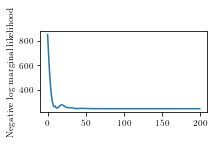

In [40]:
plt.figure()
plt.plot(losses)
plt.ylabel("Negative log marginal likelihood");

We see that the method learned a good approximation to the true (generating) parameters, up to a permutation of the states (since the labels are unidentifiable). However, results can vary with different random seeds. We may find that the rates are the same for some states, which means those states are being treated as identical, and are therefore redundant.

## Plotting the posterior over states

In [41]:
_, _, posterior_probs, _ = hmm.forward_backward(observed_counts)

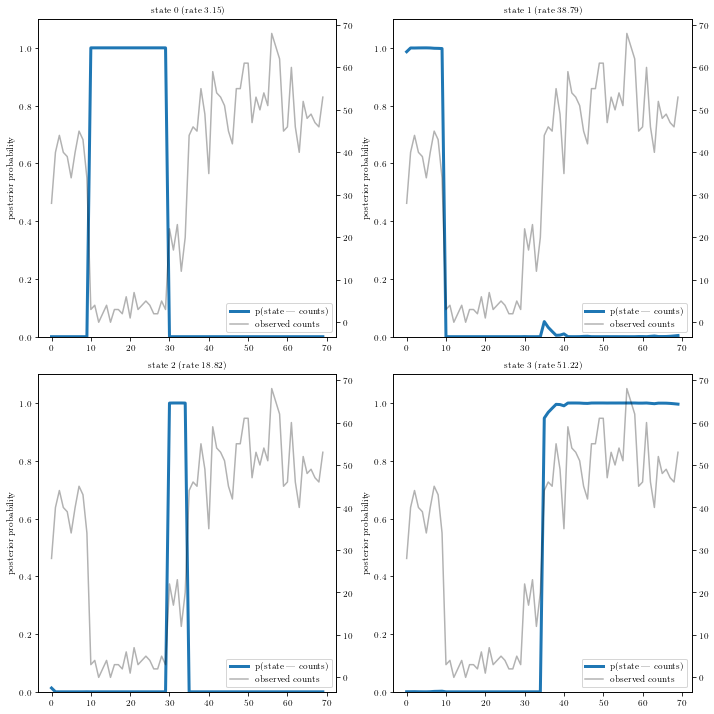

In [42]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c="tab:blue", lw=3, label="p(state | counts)")
    ax.set_ylim(0.0, 1.1)
    ax.set_ylabel("posterior probability")
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
    ax2.set_title(title)
    ax2.set_xlabel("time")
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color="white")
    ax2.grid(False)


fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1), posterior_probs[:, 0], title="state 0 (rate {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2), posterior_probs[:, 1], title="state 1 (rate {:.2f})".format(rates[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3), posterior_probs[:, 2], title="state 2 (rate {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4), posterior_probs[:, 3], title="state 3 (rate {:.2f})".format(rates[3]))
plt.tight_layout()
plt.show()

In [43]:
print(rates)

[ 3.15003431 38.7935854  18.82220998 51.21996094]


In [44]:
# max marginals
most_probable_states = jnp.argmax(posterior_probs, axis=-1)
most_probable_rates = rates[most_probable_states]

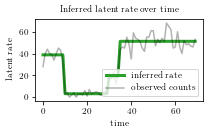

In [45]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c="tab:green", lw=3, label="inferred rate")
ax.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)
plt.show()

In [46]:
# max probaility trajectory (Viterbi)
most_probable_states = hmm.viterbi(observed_counts)
most_probable_rates = rates[most_probable_states]

saving image to /home/tensor_boy/Desktop/hmm_poisson_4states_segmentation_latexified.pdf
Figure size: [3.  1.5]


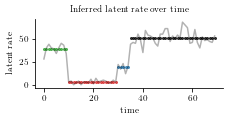

In [47]:
# Figure 29.6 (b)
plt.figure()
color_list = np.array(["tab:red", "tab:green", "tab:blue", "k"])
colors = color_list[most_probable_states]

for i in range(len(colors)):
    plt.plot(i, most_probable_rates[i], "-o", c=colors[i], mew=1, ms=2, alpha=0.75)
plt.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
plt.ylabel("latent rate")
plt.xlabel("time")
plt.title("Inferred latent rate over time")

sns.despine()
savefig("hmm_poisson_4states_segmentation")
plt.show()

## Model with unknown $K$

In general we don't know the true number of states. One way to select the 'best' model is to compute the one with the maximum marginal likelihood. Rather than summing over both discrete latent states and integrating over the unknown parameters $\lambda$, we just maximize over the parameters (empirical Bayes approximation).

$$p(x_{1:T}|K) \approx \max_\lambda \int p(x_{1:T}, z_{1:T} | \lambda, K) dz$$
We can do this by fitting a bank of separate HMMs in parallel, one for each value of $K$. We need to make them all the same size so we can batch them efficiently. To do this, we pad the transition matrices (and other paraemeter vectors) so they all have the same shape, and then use masking.

In [48]:
max_num_states = 6
states = jnp.arange(1, max_num_states + 1)

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_probs, batch_transition_probs = vmap(build_latent_state, in_axes=(0, None, None))(
    states, max_num_states, daily_change_prob
)

print("Shape of initial_state_probs: {}".format(batch_initial_state_probs.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state probs for num_states==3:\n{}".format(batch_initial_state_probs[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_probs: (6, 6)
Shape of transition probs: (6, 6, 6)
Example initial state probs for num_states==3:
[0.33333333 0.33333333 0.33333333 0.         0.         0.        ]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


In [49]:
rng_key, rng_normal = jax.random.split(rng_key)

# Define variable to represent the unknown log rates.
trainable_log_rates = jnp.log(jnp.mean(observed_counts)) + jax.random.normal(rng_normal, (max_num_states,))

## Model fitting with gradient descent

In [50]:
n_steps = 201
params, losses = vmap(fit, in_axes=(None, 0, 0, None))(
    trainable_log_rates, batch_transition_probs, batch_initial_state_probs, n_steps
)
rates = jnp.exp(params)

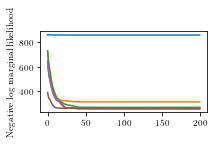

In [51]:
plt.figure()
plt.plot(losses.T)
plt.ylabel("Negative log marginal likelihood")
plt.show()

## Plot marginal likelihood of each model

In [52]:
latexify(width_scale_factor=2, fig_height=1.5)

saving image to /home/tensor_boy/Desktop/poisson_hmm_marglik_vs_k_latexified.pdf
Figure size: [3.  1.5]


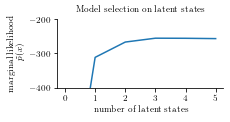

In [53]:
# fig 29.8
plt.figure()
plt.plot(-losses[:, -1])
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood \n $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

sns.despine()
savefig("poisson_hmm_marglik_vs_k")
plt.show()

## Plot posteriors

In [54]:
for i, learned_model_rates in enumerate(rates):
    print("rates for {}-state model: {}".format(i + 1, learned_model_rates[: i + 1]))

rates for 1-state model: [33.37082077]
rates for 2-state model: [ 3.57130892 46.14021407]
rates for 3-state model: [ 3.14980701 19.63675742 48.64820933]
rates for 4-state model: [18.82140537 51.21999666 38.79327666  3.15017122]
rates for 5-state model: [38.76207624 48.95703815 18.81671773  3.15015665 51.66946344]
rates for 6-state model: [38.79805872 63.09552137 38.7983422  18.81213053 51.17655488  3.15011435]


In [55]:
def posterior_marginals(trainable_log_rates, initial_state_probs, transition_probs):
    hmm = make_hmm(trainable_log_rates, transition_probs, initial_state_probs)
    _, _, marginals, _ = hmm.forward_backward(observed_counts)
    return marginals


posterior_probs = vmap(posterior_marginals, in_axes=(0, 0, 0))(
    params, batch_initial_state_probs, batch_transition_probs
)
most_probable_states = jnp.argmax(posterior_probs, axis=-1)

In [56]:
latexify(width_scale_factor=1, fig_height=3)

/home/tensor_boy/dev/probml_env/lib/python3.10/site-packages/probml_utils/plotting.py:69: UserWarning: renaming /home/tensor_boy/Desktop/hmm_poisson_segmentation_1to6.pdf to /home/tensor_boy/Desktop/hmm_poisson_segmentation_1to6_latexified.pdf because LATEXIFY is True
  warnings.warn(


saving image to /home/tensor_boy/Desktop/hmm_poisson_segmentation_1to6_latexified.pdf
Figure size: [6. 3.]


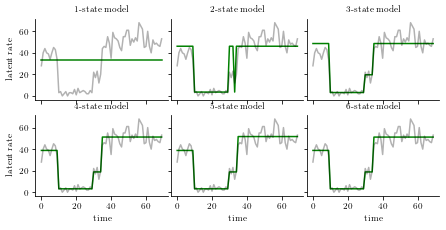

In [57]:
# 29.7
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

for i, learned_model_rates in enumerate(rates):
    ax = axes[i // 3, i - (i // 3 * 3)]
    ax.plot(learned_model_rates[most_probable_states[i]], c="green", label="inferred rate")
    ax.plot(observed_counts, c="black", alpha=0.3, label="observed counts")

    if i % 3 == 0:
        ax.set_ylabel("latent rate")
    if i // 3 == 1:
        ax.set_xlabel("time")
    ax.set_title(f"{i+1}-state model")

sns.despine()
fig.tight_layout()

savefig("hmm_poisson_segmentation_1to6.pdf")